# Conservative Q-Learning (CQL) 离线强化学习训练

本 Notebook 实现离散动作空间的 CQL 训练流程，用于 ICU 药物剂量优化。

**数据**: ready_data1.csv  
**动作空间**: {0, 1, 2} (离散分类)  
**算法**: Conservative Q-Learning (CQL)


In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 设置设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {DEVICE}")

# 设置中文字体（用于可视化）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


使用设备: cpu


## 1. 数据加载与预处理


In [2]:
# 定义数据列
STATE_COLS = [
    "vanco_level(ug/mL)",
    "creatinine(mg/dL)",
    "temperature",
    "sbp",
    "heart_rate",
    "wbc(K/uL)",
    "bun(mg/dL)",
    "creatinine(mg/dL)_is_missing",
    "wbc(K/uL)_is_missing",
    "bun(mg/dL)_is_missing",
    "cre_diff",
    "wbc_diff",
    "warning",
]

ACTION_COL = "totalamount_mg"
REWARD_COL = "step_reward"
TIME_COLS = ["stay_id", "step_4hr"]

# 加载数据
df = pd.read_csv("ready_data1.csv")
print(f"数据形状: {df.shape}")
print(f"\n动作分布:")
print(df[ACTION_COL].value_counts().sort_index())
print(f"\n动作空间大小: {df[ACTION_COL].nunique()}")


数据形状: (2113, 17)

动作分布:
totalamount_mg
0    1882
1     199
2      32
Name: count, dtype: int64

动作空间大小: 3


In [21]:
# 数据预处理
# 1. 定义预处理函数（解决代沟和权重问题）
def preprocess_rl_data(df):
    # 按照病人ID和时间排序，确保时序正确
    df = df.sort_values(['stay_id', 'step_4hr'])
    
    # 【解决代沟问题】：识别病人的最后一行
    # 如果下一行的 stay_id 不同，则说明当前病人轨迹结束，done=1
    df['done'] = (df['stay_id'] != df['stay_id'].shift(-1)).astype(np.float32)
    df.loc[df.index[-1], 'done'] = 1.0
    
    # 【解决动作不平衡】：计算动作权重
    # 针对动作 0, 1, 2 分别计算权重，样本越少权重越大
    action_counts = df[ACTION_COL].value_counts().sort_index()
    weights = 1.0 / (action_counts + 0.1) # 加 0.1 防止除以0
    weights = weights / weights.sum() * len(action_counts) # 归一化权重使均值为1
    action_weights_tensor = torch.FloatTensor(weights.values).to(DEVICE)
    
    return df, action_weights_tensor

# 2. 执行处理
df, action_weights = preprocess_rl_data(df)
# 填充缺失值（差分特征的首行可能是NaN）
df[STATE_COLS] = df[STATE_COLS].fillna(df[STATE_COLS].median())

# 按 stay_id 划分训练集和验证集（避免数据泄漏）
stay_ids = df["stay_id"].unique()
train_stay_ids, val_stay_ids = train_test_split(stay_ids, test_size=0.2, random_state=42)
train_df = df[df["stay_id"].isin(train_stay_ids)].reset_index(drop=True)
val_df = df[df["stay_id"].isin(val_stay_ids)].reset_index(drop=True)

print(f"训练集: {len(train_df)} 条记录, {len(train_stay_ids)} 个病人")
print(f"验证集: {len(val_df)} 条记录, {len(val_stay_ids)} 个病人")


训练集: 1805 条记录, 46 个病人
验证集: 308 条记录, 12 个病人


In [16]:
# 标准化状态特征
state_scaler = StandardScaler()
train_states = state_scaler.fit_transform(train_df[STATE_COLS])
val_states = state_scaler.transform(val_df[STATE_COLS])

# 动作已经是离散的 0, 1, 2，直接转换为整数
train_actions = train_df[ACTION_COL].values.astype(np.int64)
val_actions = val_df[ACTION_COL].values.astype(np.int64)

# 奖励
r_min = train_df[REWARD_COL].min()
r_max = train_df[REWARD_COL].max()
r_range = r_max - r_min

# 避免除以0
if r_range == 0: r_range = 1

train_rewards = (train_df[REWARD_COL].values.astype(np.float32) - r_min) / r_range
val_rewards = (val_df[REWARD_COL].values.astype(np.float32) - r_min) / r_range

print(f"状态维度: {train_states.shape[1]}")
print(f"动作空间: {[0, 1, 2]}")
print(f"训练集奖励范围: [{train_rewards.min():.2f}, {train_rewards.max():.2f}]")


状态维度: 13
动作空间: [0, 1, 2]
训练集奖励范围: [0.00, 1.00]


In [22]:
# === 修改后的 Cell 5 ===

def build_next_states(df_src, scaled_states):
    """
    利用预处理好的 done 标记简化构建下一状态
    """
    # 1. 提取我们已经在 Cell 3 中计算好的 done 标记
    dones = df_src['done'].values.astype(np.float32)
    
    # 2. 构建 next_states
    # 我们将状态数组向下移动一位。
    # 对于每一行 i，它的 next_state 就是 scaled_states[i+1]
    next_states = np.roll(scaled_states, -1, axis=0)
    
    # 3. 处理边界条件：
    # 如果当前行是 done (病人的最后一步)，它的 next_state 其实是无效的
    # 我们通常将其设为全 0，或者保持原样（因为在 loss 计算中会被 (1-dones) 过滤掉）
    # 为了严谨，我们将 done 为 1 的行的 next_state 清零
    next_states[dones == 1.0] = 0
    
    return next_states.astype(np.float32), dones

# 调用函数
train_next_states, train_dones = build_next_states(train_df, train_states)
val_next_states, val_dones = build_next_states(val_df, val_states)

print(f"训练集 done 比例: {train_dones.mean():.3f}")
print(f"验证集 done 比例: {val_dones.mean():.3f}")


训练集 done 比例: 0.025
验证集 done 比例: 0.039


## 2. 数据集定义


In [6]:
class RLDataset(Dataset):
    """强化学习数据集"""
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = torch.FloatTensor(states)
        self.actions = torch.LongTensor(actions)
        self.rewards = torch.FloatTensor(rewards)
        self.next_states = torch.FloatTensor(next_states)
        self.dones = torch.FloatTensor(dones)
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx]
        )

# 创建数据集和数据加载器
train_dataset = RLDataset(train_states, train_actions, train_rewards, train_next_states, train_dones)
val_dataset = RLDataset(val_states, val_actions, val_rewards, val_next_states, val_dones)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")


训练批次数: 7
验证批次数: 2


## 3. CQL 模型定义（离散动作版本）


In [7]:
def create_mlp(input_dim, output_dim, hidden_sizes=(256, 256), activation=nn.ReLU):
    """创建多层感知机"""
    layers = []
    last_dim = input_dim
    for h in hidden_sizes:
        layers.extend([nn.Linear(last_dim, h), activation()])
        last_dim = h
    layers.append(nn.Linear(last_dim, output_dim))
    return nn.Sequential(*layers)

class DiscreteQNetwork(nn.Module):
    """离散动作的 Q 网络：输入状态，输出每个动作的 Q 值"""
    def __init__(self, state_dim, action_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = create_mlp(state_dim, action_dim, hidden_sizes)
    
    def forward(self, state):
        """返回 Q(s, a) for all a"""
        return self.net(state)  # [batch_size, action_dim]

class CategoricalPolicy(nn.Module):
    """分类策略：输出每个动作的概率"""
    def __init__(self, state_dim, action_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.net = create_mlp(state_dim, action_dim, hidden_sizes)
    
    def forward(self, state):
        """返回动作概率分布"""
        logits = self.net(state)
        return torch.distributions.Categorical(logits=logits)
    
    def sample(self, state):
        """采样动作"""
        dist = self(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def get_probs(self, state):
        """获取动作概率"""
        dist = self(state)
        return dist.probs

class CQLAgent(nn.Module):
    """CQL Agent: Twin Q + Policy"""
    def __init__(self, state_dim, action_dim, hidden_sizes=(256, 256)):
        super().__init__()
        self.q1 = DiscreteQNetwork(state_dim, action_dim, hidden_sizes)
        self.q2 = DiscreteQNetwork(state_dim, action_dim, hidden_sizes)
        self.q1_target = DiscreteQNetwork(state_dim, action_dim, hidden_sizes)
        self.q2_target = DiscreteQNetwork(state_dim, action_dim, hidden_sizes)
        self.policy = CategoricalPolicy(state_dim, action_dim, hidden_sizes)
        
        # 初始化目标网络
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
    
    @torch.no_grad()
    def soft_update(self, tau=0.005):
        """软更新目标网络"""
        for target_param, param in zip(self.q1_target.parameters(), self.q1.parameters()):
            target_param.data.mul_(1 - tau).add_(tau * param.data)
        for target_param, param in zip(self.q2_target.parameters(), self.q2.parameters()):
            target_param.data.mul_(1 - tau).add_(tau * param.data)
    
    def get_q_values(self, state, action=None):
        """获取 Q 值"""
        q1_vals = self.q1(state)  # [batch, action_dim]
        q2_vals = self.q2(state)
        
        if action is not None:
            # 返回指定动作的 Q 值
            q1 = q1_vals.gather(1, action.unsqueeze(1))
            q2 = q2_vals.gather(1, action.unsqueeze(1))
            return q1, q2
        return q1_vals, q2_vals

# 初始化模型
state_dim = train_states.shape[1]
action_dim = 3  # 动作空间 {0, 1, 2}
agent = CQLAgent(state_dim, action_dim).to(DEVICE)

print(f"状态维度: {state_dim}")
print(f"动作维度: {action_dim}")
print(f"模型参数数量: {sum(p.numel() for p in agent.parameters()):,}")


状态维度: 13
动作维度: 3
模型参数数量: 350,735


## 4. CQL 损失函数


In [23]:
def compute_cql_loss(agent, batch, config, action_weights):
    """
    改进后的 CQL 损失函数
    1. 应用 action_weights 解决样本不平衡
    2. 使用 Huber Loss 代替 MSE 防止梯度爆炸
    3. 修复了 Target Q 的计算逻辑
    """
    states, actions, rewards, next_states, dones = batch
    states = states.to(DEVICE)
    actions = actions.to(DEVICE)
    rewards = rewards.to(DEVICE).unsqueeze(1)
    next_states = next_states.to(DEVICE)
    dones = dones.to(DEVICE).unsqueeze(1)
    
    # ========== 1. Bellman 误差 (Q Loss) ==========
    q1_vals, q2_vals = agent.get_q_values(states)
    q1_data = q1_vals.gather(1, actions.unsqueeze(1))
    q2_data = q2_vals.gather(1, actions.unsqueeze(1))
    
    with torch.no_grad():
        # 使用当前策略获取下一状态的动作分布
        next_dist = agent.policy(next_states)
        next_probs = next_dist.probs
        
        # 计算目标 Q 值: E_a~π[Q_target(s', a)]
        next_q1_target = agent.q1_target(next_states)
        next_q2_target = agent.q2_target(next_states)
        next_q_target = torch.min(next_q1_target, next_q2_target)
        
        # 期望值计算
        expected_next_q = (next_probs * next_q_target).sum(dim=1, keepdim=True)
        
        # 核心：如果 dones=1，则不加上未来的 Q 值
        backup = rewards + config['gamma'] * (1 - dones) * expected_next_q
    
    # 使用 Huber Loss 代替 MSE，对异常 reward 更鲁棒
    q1_loss = torch.nn.functional.huber_loss(q1_data, backup, delta=1.0)
    q2_loss = torch.nn.functional.huber_loss(q2_data, backup, delta=1.0)
    
    # ========== 2. CQL 正则项 (离散版本) ==========
    # logsumexp(Q) 惩罚未见过的动作，Q_data 奖励数据集中的动作
    cql1 = (torch.logsumexp(q1_vals, dim=1, keepdim=True) - q1_data).mean()
    cql2 = (torch.logsumexp(q2_vals, dim=1, keepdim=True) - q2_data).mean()
    
    # ========== 3. 策略损失 (加权 Behavior Cloning) ==========
    policy_dist = agent.policy(states)
    log_probs = policy_dist.log_prob(actions)
    
    # 根据动作类别分配权重，解决 0 剂量样本过多的问题
    batch_weights = action_weights[actions.long()]
    policy_loss = -(log_probs * batch_weights).mean()
    
    # 总损失计算
    total_loss = q1_loss + q2_loss + config['alpha'] * (cql1 + cql2) + policy_loss
    
    info = {
        'total_loss': total_loss.item(),
        'q_loss': (q1_loss + q2_loss).item(),
        'policy_loss': policy_loss.item(),
        'cql_stat': (cql1 + cql2).item(),
        'q_mean': q1_data.mean().item()
    }
    
    return total_loss, info

In [28]:
# 训练配置
config = {
    'batch_size': 256,
    'lr': 1e-4,
    'gamma': 0.99,
    'alpha': 0.01,  # CQL 正则系数
    'tau': 0.005,  # 目标网络软更新系数
    'epochs': 30,
    'steps_per_epoch': 1000,
    'val_interval': 2,
}

# 优化器
optimizer = optim.Adam(
    list(agent.q1.parameters()) + 
    list(agent.q2.parameters()) + 
    list(agent.policy.parameters()),
    lr=config['lr']
)

print("训练配置:")
for k, v in config.items():
    print(f"  {k}: {v}")


训练配置:
  batch_size: 256
  lr: 0.0001
  gamma: 0.99
  alpha: 0.01
  tau: 0.005
  epochs: 30
  steps_per_epoch: 1000
  val_interval: 2


In [ ]:
# 训练循环
train_losses = []
val_losses = []
train_q1_means = []
train_cql1_vals = []

best_val_loss = float('inf')
best_model_state = None

print("开始训练...")
for epoch in range(1, config['epochs'] + 1):
    agent.train()
    epoch_losses = []
    epoch_q1_means = []
    epoch_cql1_vals = []
    
    # 训练一个 epoch
    for step in range(config['steps_per_epoch']):
        batch = next(iter(train_loader))
        loss, info = compute_cql_loss(agent, batch, config, action_weights)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.parameters(), 5.0)
        optimizer.step()
        agent.soft_update(config['tau'])
        
        epoch_losses.append(info['total_loss'])
        epoch_q1_means.append(info['q_mean'])
        epoch_cql1_vals.append(info['cql_stat'])
    
    # 记录训练指标
    avg_loss = np.mean(epoch_losses)
    avg_q1 = np.mean(epoch_q1_means)
    avg_cql1 = np.mean(epoch_cql1_vals)
    train_losses.append(avg_loss)
    train_q1_means.append(avg_q1)
    train_cql1_vals.append(avg_cql1)
    
    # 验证
    if epoch % config['val_interval'] == 0:
        agent.eval()
        val_loss_list = []
        with torch.no_grad():
            for batch in val_loader:
                loss, _ = compute_cql_loss(agent, batch, config, action_weights)
                val_loss_list.append(loss.item())
        val_loss = np.mean(val_loss_list)
        val_losses.append((epoch, val_loss))
        agent.train()
        
        print(f"Epoch {epoch:3d} | 训练损失: {avg_loss:.4f} | Q1均值: {avg_q1:.4f} | CQL1: {avg_cql1:.4f} | 验证损失: {val_loss:.4f}")
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {
                'agent': agent.state_dict(),
                'state_scaler': state_scaler,
                'config': config,
            }
            torch.save(best_model_state, 'cql_best_model.pt')
    else:
        print(f"Epoch {epoch:3d} | 训练损失: {avg_loss:.4f} | Q1均值: {avg_q1:.4f} | CQL1: {avg_cql1:.4f}")

print(f"\n训练完成！最佳验证损失: {best_val_loss:.4f}")


开始训练...
Epoch   1 | 训练损失: 8.2822 | Q1均值: -96.8285 | CQL1: 17.9126
Epoch   2 | 训练损失: 7.9219 | Q1均值: -95.2527 | CQL1: 17.4236 | 验证损失: 133.2506
Epoch   3 | 训练损失: 7.6523 | Q1均值: -93.2597 | CQL1: 16.9794
Epoch   4 | 训练损失: 7.3838 | Q1均值: -91.8585 | CQL1: 16.5863 | 验证损失: 133.4800
Epoch   5 | 训练损失: 6.9965 | Q1均值: -90.3374 | CQL1: 16.1655
Epoch   6 | 训练损失: 6.7807 | Q1均值: -88.8250 | CQL1: 15.4974 | 验证损失: 134.1310
Epoch   7 | 训练损失: 6.5506 | Q1均值: -87.4472 | CQL1: 14.8800
Epoch   8 | 训练损失: 6.2876 | Q1均值: -86.0435 | CQL1: 14.5850 | 验证损失: 133.5121
Epoch   9 | 训练损失: 6.0488 | Q1均值: -84.4289 | CQL1: 14.3519
Epoch  10 | 训练损失: 5.8565 | Q1均值: -83.4501 | CQL1: 14.0655 | 验证损失: 136.3283
Epoch  11 | 训练损失: 5.6701 | Q1均值: -81.8578 | CQL1: 13.8776
Epoch  12 | 训练损失: 5.4473 | Q1均值: -80.5936 | CQL1: 13.5344 | 验证损失: 135.9563
Epoch  13 | 训练损失: 5.2077 | Q1均值: -79.1392 | CQL1: 13.2525
Epoch  14 | 训练损失: 5.0192 | Q1均值: -77.9116 | CQL1: 13.0011 | 验证损失: 129.5813
Epoch  15 | 训练损失: 4.8146 | Q1均值: -76.5936 | CQL1: 12.7789


## 6. 可视化评估


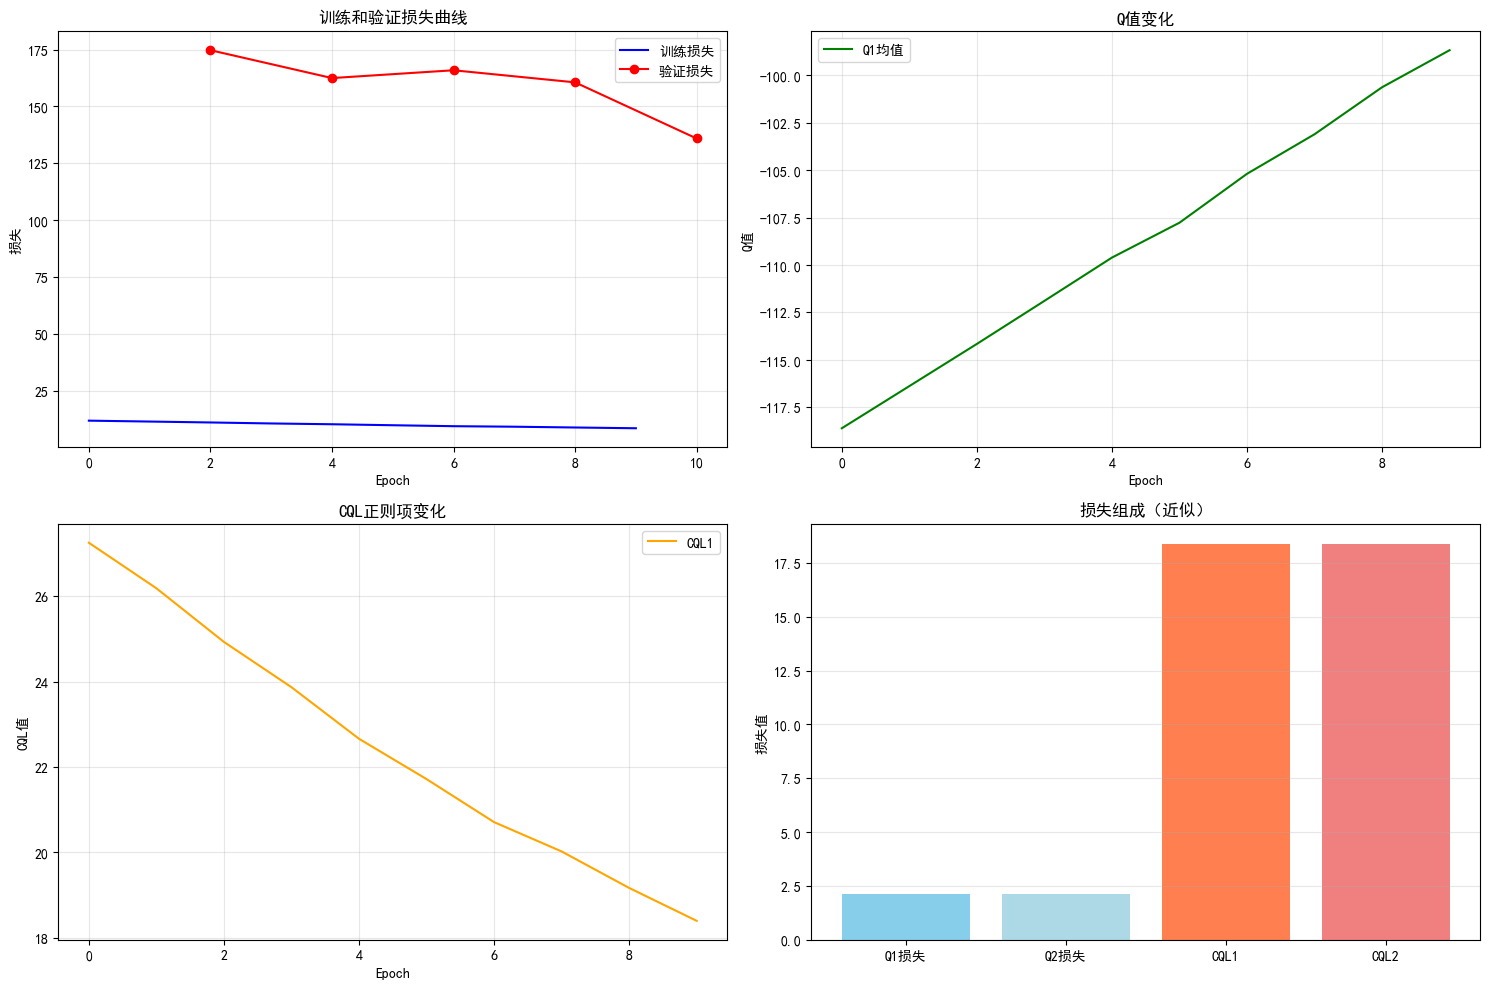

In [29]:
# 1. 训练曲线
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 训练损失
axes[0, 0].plot(train_losses, label='训练损失', color='blue')
if val_losses:
    val_epochs, val_vals = zip(*val_losses)
    axes[0, 0].plot(val_epochs, val_vals, label='验证损失', color='red', marker='o')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('损失')
axes[0, 0].set_title('训练和验证损失曲线')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q值均值
axes[0, 1].plot(train_q1_means, label='Q1均值', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Q值')
axes[0, 1].set_title('Q值变化')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CQL正则项
axes[1, 0].plot(train_cql1_vals, label='CQL1', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('CQL值')
axes[1, 0].set_title('CQL正则项变化')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 损失分解（最后一个epoch）
axes[1, 1].bar(['Q1损失', 'Q2损失', 'CQL1', 'CQL2'], 
               [train_losses[-1]/4, train_losses[-1]/4, 
                train_cql1_vals[-1], train_cql1_vals[-1]], 
               color=['skyblue', 'lightblue', 'coral', 'lightcoral'])
axes[1, 1].set_ylabel('损失值')
axes[1, 1].set_title('损失组成（近似）')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


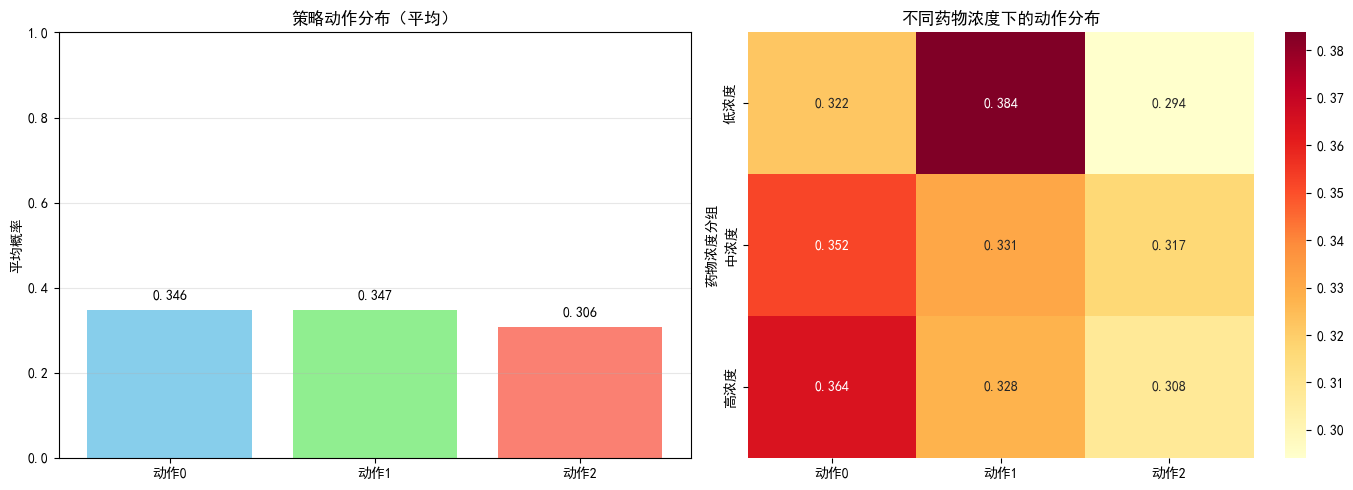


策略动作分布（平均）:
  动作0: 0.346
  动作1: 0.347
  动作2: 0.306


In [13]:
# 2. 策略分析：在不同状态下动作选择分布
agent.eval()
with torch.no_grad():
    # 随机采样一些状态
    sample_indices = np.random.choice(len(val_states), min(100, len(val_states)), replace=False)
    sample_states = torch.FloatTensor(val_states[sample_indices]).to(DEVICE)
    
    # 获取策略概率
    policy_probs = agent.policy.get_probs(sample_states).cpu().numpy()  # [n_samples, 3]
    
    # 计算平均动作分布
    avg_probs = policy_probs.mean(axis=0)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 动作概率分布
    axes[0].bar(['动作0', '动作1', '动作2'], avg_probs, color=['skyblue', 'lightgreen', 'salmon'])
    axes[0].set_ylabel('平均概率')
    axes[0].set_title('策略动作分布（平均）')
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 添加数值标签
    for i, v in enumerate(avg_probs):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
    
    # 动作分布热力图（按状态分组）
    # 根据状态特征分组（例如：根据药物浓度）
    vanco_levels = val_df.iloc[sample_indices]['vanco_level(ug/mL)'].values
    bins = np.percentile(vanco_levels, [0, 33, 67, 100])
    groups = np.digitize(vanco_levels, bins) - 1
    
    group_probs = []
    group_labels = ['低浓度', '中浓度', '高浓度']
    for g in range(3):
        mask = groups == g
        if mask.sum() > 0:
            group_probs.append(policy_probs[mask].mean(axis=0))
        else:
            group_probs.append([0, 0, 0])
    
    group_probs = np.array(group_probs)
    sns.heatmap(group_probs, annot=True, fmt='.3f', cmap='YlOrRd', 
                xticklabels=['动作0', '动作1', '动作2'],
                yticklabels=group_labels,
                ax=axes[1])
    axes[1].set_title('不同药物浓度下的动作分布')
    axes[1].set_ylabel('药物浓度分组')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n策略动作分布（平均）:")
    print(f"  动作0: {avg_probs[0]:.3f}")
    print(f"  动作1: {avg_probs[1]:.3f}")
    print(f"  动作2: {avg_probs[2]:.3f}")


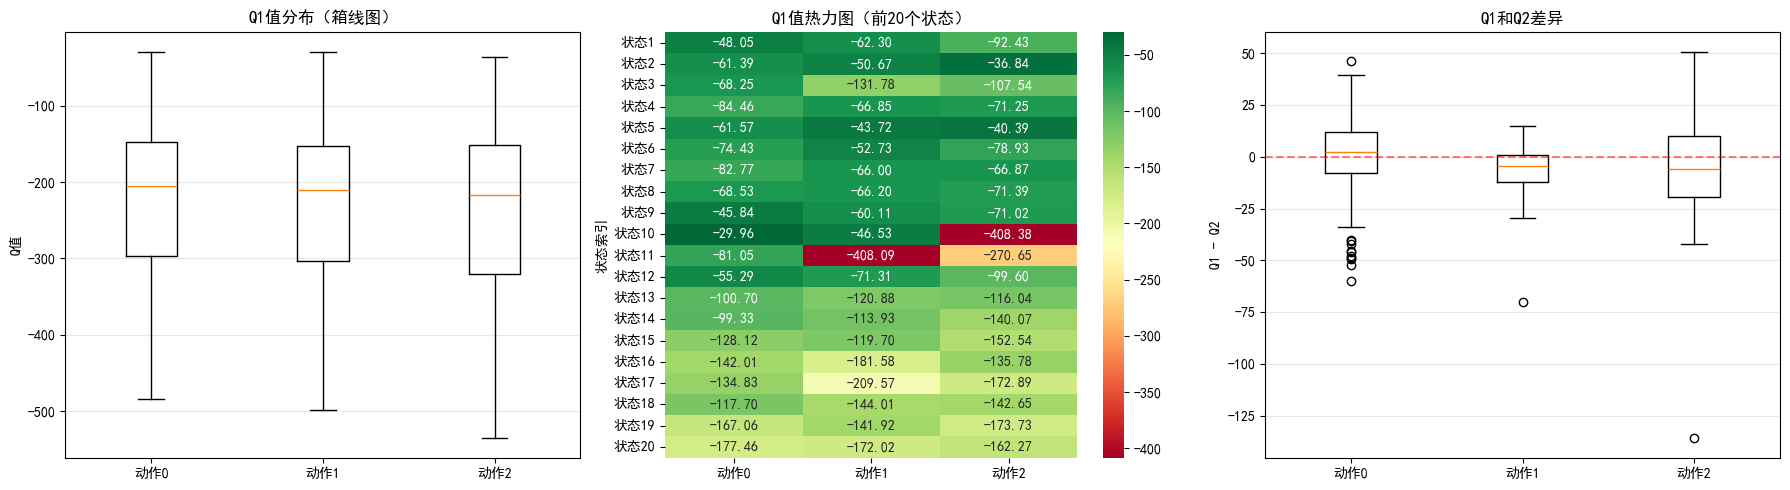


Q值统计:
  Q1均值: -230.340
  Q2均值: -226.971
  Q1-Q2差异: -3.369


In [14]:
# 3. Q值分析
agent.eval()
with torch.no_grad():
    sample_states = torch.FloatTensor(val_states[:100]).to(DEVICE)
    q1_vals = agent.q1(sample_states).cpu().numpy()  # [100, 3]
    q2_vals = agent.q2(sample_states).cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Q值分布箱线图
    axes[0].boxplot([q1_vals[:, 0], q1_vals[:, 1], q1_vals[:, 2]], 
                    labels=['动作0', '动作1', '动作2'])
    axes[0].set_ylabel('Q值')
    axes[0].set_title('Q1值分布（箱线图）')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Q值热力图（按状态）
    # 选择前20个状态
    q1_subset = q1_vals[:20]
    sns.heatmap(q1_subset, annot=True, fmt='.2f', cmap='RdYlGn',
                xticklabels=['动作0', '动作1', '动作2'],
                yticklabels=[f'状态{i+1}' for i in range(20)],
                ax=axes[1])
    axes[1].set_title('Q1值热力图（前20个状态）')
    axes[1].set_ylabel('状态索引')
    
    # Q值差异（Q1 - Q2）
    q_diff = q1_vals - q2_vals
    axes[2].boxplot([q_diff[:, 0], q_diff[:, 1], q_diff[:, 2]],
                    labels=['动作0', '动作1', '动作2'])
    axes[2].set_ylabel('Q1 - Q2')
    axes[2].set_title('Q1和Q2差异')
    axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nQ值统计:")
    print(f"  Q1均值: {q1_vals.mean():.3f}")
    print(f"  Q2均值: {q2_vals.mean():.3f}")
    print(f"  Q1-Q2差异: {(q1_vals - q2_vals).mean():.3f}")


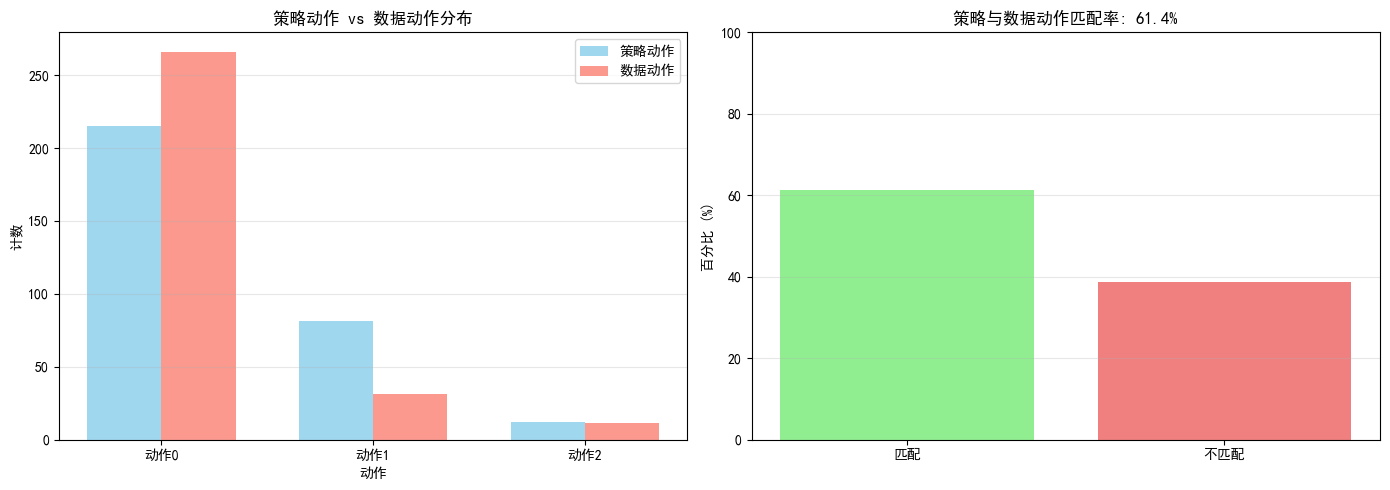


动作分布对比:
  策略: 动作0=215, 动作1=81, 动作2=12
  数据: 动作0=266, 动作1=31, 动作2=11
  匹配率: 61.36%


In [15]:
# 4. 策略 vs 数据动作分布对比
agent.eval()
with torch.no_grad():
    # 在验证集上评估
    val_states_tensor = torch.FloatTensor(val_states).to(DEVICE)
    policy_probs = agent.policy.get_probs(val_states_tensor).cpu().numpy()
    
    # 策略选择的动作（贪婪）
    policy_actions = policy_probs.argmax(axis=1)
    
    # 数据中的动作
    data_actions = val_actions
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 动作分布对比
    policy_counts = np.bincount(policy_actions, minlength=3)
    data_counts = np.bincount(data_actions, minlength=3)
    
    x = np.arange(3)
    width = 0.35
    axes[0].bar(x - width/2, policy_counts, width, label='策略动作', color='skyblue', alpha=0.8)
    axes[0].bar(x + width/2, data_counts, width, label='数据动作', color='salmon', alpha=0.8)
    axes[0].set_xlabel('动作')
    axes[0].set_ylabel('计数')
    axes[0].set_title('策略动作 vs 数据动作分布')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(['动作0', '动作1', '动作2'])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 动作匹配率
    match_rate = (policy_actions == data_actions).mean()
    axes[1].bar(['匹配', '不匹配'], 
                [match_rate * 100, (1-match_rate) * 100],
                color=['lightgreen', 'lightcoral'])
    axes[1].set_ylabel('百分比 (%)')
    axes[1].set_title(f'策略与数据动作匹配率: {match_rate*100:.1f}%')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n动作分布对比:")
    print(f"  策略: 动作0={policy_counts[0]}, 动作1={policy_counts[1]}, 动作2={policy_counts[2]}")
    print(f"  数据: 动作0={data_counts[0]}, 动作1={data_counts[1]}, 动作2={data_counts[2]}")
    print(f"  匹配率: {match_rate*100:.2f}%")


In [ ]:
# 5. 轨迹分析：选择一个完整的病人轨迹
agent.eval()
with torch.no_grad():
    # 选择一个有足够步骤的病人
    stay_id = val_stay_ids[0]
    stay_data = val_df[val_df['stay_id'] == stay_id].sort_values('step_4hr')
    stay_indices = stay_data.index.values
    
    stay_states = torch.FloatTensor(val_states[stay_indices]).to(DEVICE)
    stay_actions_data = val_actions[stay_indices]
    stay_rewards = val_rewards[stay_indices]
    
    # 策略动作和Q值
    policy_probs = agent.policy.get_probs(stay_states).cpu().numpy()
    policy_actions = policy_probs.argmax(axis=1)
    q1_vals = agent.q1(stay_states).cpu().numpy()
    
    # 可视化
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    # 动作选择
    axes[0].plot(stay_data['step_4hr'], stay_actions_data, 'o-', label='数据动作', color='blue', markersize=8)
    axes[0].plot(stay_data['step_4hr'], policy_actions, 's--', label='策略动作', color='red', markersize=6)
    axes[0].set_xlabel('时间步 (4小时)')
    axes[0].set_ylabel('动作')
    axes[0].set_title(f'病人 {stay_id} 的动作选择轨迹')
    axes[0].set_yticks([0, 1, 2])
    axes[0].set_yticklabels(['动作0', '动作1', '动作2'])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 奖励
    axes[1].plot(stay_data['step_4hr'], stay_rewards, 'o-', color='green', markersize=6)
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1].set_xlabel('时间步 (4小时)')
    axes[1].set_ylabel('奖励')
    axes[1].set_title('奖励轨迹')
    axes[1].grid(True, alpha=0.3)
    
    # Q值
    for a in range(3):
        axes[2].plot(stay_data['step_4hr'], q1_vals[:, a], 
                    label=f'Q(动作{a})', marker='o', markersize=4)
    axes[2].set_xlabel('时间步 (4小时)')
    axes[2].set_ylabel('Q值')
    axes[2].set_title('Q值轨迹')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n轨迹分析（病人 {stay_id}）:")
    print(f"  总步数: {len(stay_data)}")
    print(f"  累计奖励: {stay_rewards.sum():.2f}")
    print(f"  策略动作匹配率: {(policy_actions == stay_actions_data).mean()*100:.1f}%")


## 7. 模型保存与总结


In [ ]:
# 保存最终模型
final_model = {
    'agent': agent.state_dict(),
    'state_scaler': state_scaler,
    'config': config,
    'state_dim': state_dim,
    'action_dim': action_dim,
}

torch.save(final_model, 'cql_final_model.pt')
print("模型已保存到: cql_final_model.pt")
print("最佳模型已保存到: cql_best_model.pt")

# 训练总结
print("\n" + "="*60)
print("训练总结")
print("="*60)
print(f"总训练轮数: {config['epochs']}")
print(f"最佳验证损失: {best_val_loss:.4f}")
print(f"最终训练损失: {train_losses[-1]:.4f}")
print(f"最终Q1均值: {train_q1_means[-1]:.4f}")
print(f"最终CQL1值: {train_cql1_vals[-1]:.4f}")
print(f"\n模型文件:")
print(f"  - cql_best_model.pt (最佳验证性能)")
print(f"  - cql_final_model.pt (最终模型)")
print("="*60)
